------------------------------
Glimpse of the DF:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


------------------------------
Statistical summary of titanic DF:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


------------------------------
Finding NaN values:


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Fare max value 512.3292
   Survived  Pclass     Sex   Age     Fare
0         0       3    male  22.0   7.2500
1         1       1  female  38.0  71.2833
2         1       3  female  26.0   7.9250
3         1       1  female  35.0  53.1000
4         0       3    male  35.0   8.0500


Index(['Survived', 'Pclass', 'Sex', 'Age', 'Fare'], dtype='object')

Survived    0
Pclass      0
Sex         0
Age         0
Fare        0
dtype: int64

Survived      int64
Pclass        int64
Sex           int64
Age           int64
Fare        float64
dtype: object

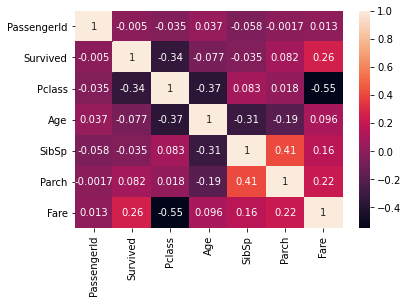

In [56]:
import os
#import modal
#import great_expectations as ge
#import hopsworks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns


#project = hopsworks.login()
#fs = project.get_feature_store()

titanic_df = pd.read_csv("https://raw.githubusercontent.com/ID2223KTH/id2223kth.github.io/master/assignments/lab1/titanic.csv")
#X_train, X_test, y_train, y_test = train_test_split(titanic_df, test_size=0.2)

# Print shapes of train and test data
#print(X_train.shape, X_test.shape)
#print(y_train.shape, y_test.shape)
# Exploratory analysis

# First instances
print("-"*30)
print("Glimpse of the DF:")
display(titanic_df.head(5))

# Descriptive stats for titanic df
print("-"*30)
print("Statistical summary of titanic DF:")
display(titanic_df.describe())

# Find NaNs
# Age - 177 and Cabin - 687 and embarked - 2
# ML algos doesn't like missing values so we need to handle them
print("-"*30)
print("Finding NaN values:")
display(titanic_df.isnull().sum())

# I didn't do any proper feature engineering, instead I found an article mentioning 
# that these are the most important features for this dataset:
# Sex, Age, Fare, Pclass
# I drop the less important features and Cabin (since it has so many missing values)

# Max value of fair
print("Fare max value", titanic_df['Fare'].max())

# Check correlation among features
corr = titanic_df.corr()
sns.heatmap(corr, annot=True)

# Drop less important columns
titanic_df.drop(['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch', 'Cabin', 'Embarked'], axis=1, inplace=True)
print(titanic_df.head(5))
display(titanic_df.columns) # THIS is what we will put in our feature store! Not sure if passanger ID needs to be included.

# Handle missing values (age)
titanic_df['Age'].fillna((titanic_df['Age'].mean()), inplace=True)
bins = [-np.infty, 20, 25, 29, 30, 40, np.infty]
titanic_df['Age'] = pd.cut(x=titanic_df['Age'], bins=bins, labels=False)
display(titanic_df.isnull().sum()) # it worked

# Map to numeric values (gender)
categories = {"female": 1, "male": 0}
titanic_df['Sex']= titanic_df['Sex'].map(categories)

titanic_df['Fare'] = titanic_df["Fare"].fillna(-1)

# Check that all columns are numerical
display(titanic_df.dtypes)

In [57]:
# Split the data into train and test. Then we perform normalization.

# Keeping and dropping label. We save it later for seeing how well the model predicted
labels = titanic_df['Survived']
titanic_df = titanic_df.drop('Survived', axis=1)  # Dropping label to normalize

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(titanic_df, labels, test_size=0.15, random_state=32)

print(X_train.shape)# Training data
print(X_test.shape) # Test set
print(y_train.shape) # labels for training data
print(y_test.shape) # labels for test set


# Normalize the data so that the model converges faster 
# convergence = a state when the loss is around the final value

# Normalizing using MinMaxScaler
# transforms numeric values to a given range. Default = 0,1 which we use
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)

scaled_train = pd.DataFrame(scaled_train, columns=X_train.columns, index=X_train.index)
display(scaled_train.head(5))

# TODO: Train model, split data, make predictions, evaluate, hyperparam tuning (approx 1 h of work), write comments!

(757, 4)
(134, 4)
(757,)
(134,)


,Pclass,Sex,Age,Fare
91,1.0,0.0,0.0,0.015330
441,1.0,0.0,0.0,0.018543
440,0.5,1.0,1.0,0.051237
370,0.0,0.0,0.2,0.108215
365,1.0,0.0,0.6,0.014151


In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

# Random search
grid_params = {'n_estimators': [10, 20, 50, 100], # Num of DTs in the forest. Default = 10
               'max_features': ['auto', 'sqrt'], # Max features at each split
               'max_depth': [10, 20, 50, None], # Depth of each DT in the forest. None = no limits and the trees grow as big as they need
               'min_samples_split': [2, 5, 10, 15], # Minimum samples to perform a split
               'min_samples_leaf': [1, 2, 4, 6], # Min num of samples at the leaf node of each tree
               'bootstrap': [True, False]} # random 

grid = GridSearchCV(clf,param_grid=grid_params,scoring='accuracy') # x validation default = 5



model_grid = grid.fit(X_train,y_train)


print('Best hyperparameters are: '+str(model_grid.best_params_))
print('Best score is: '+str(model_grid.best_score_))


#Train the model using the training sets y_pred=clf.predict(X_test)
#clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)
#print("   Accuracy: {}".format(metrics.accuracy_score(y_test, y_pred)))
#print(classification_report(y_test,y_pred))

#display(y_test)

#print(y_pred)

Best hyperparameters are: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
Best score is: 0.8097507842453815


In [59]:
# Refined search

'''
Last search:
Best hyperparameters are: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 20}
Best score is: 0.81238236319275
'''

grid_params = {'n_estimators': [15, 20, 25, 30], # Num of DTs in the forest. Default = 10
               'max_features': ['sqrt'], # Max features at each split
               'max_depth': [None], # Depth of each DT in the forest. None = no limits and the trees grow as big as they need
               'min_samples_split': [8, 9, 10], # Minimum samples to perform a split
               'min_samples_leaf': [1, 2, 5], # Min num of samples at the leaf node of each tree
               'bootstrap': [True]} # random 

grid = GridSearchCV(clf,param_grid=grid_params,scoring='accuracy') # x validation default = 5



model_grid = grid.fit(X_train,y_train)


print('Best hyperparameters are: '+str(model_grid.best_params_))
print('Best score is: '+str(model_grid.best_score_))

Best hyperparameters are: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 25}
Best score is: 0.8084262809341233


In [60]:
final_clf = clf = RandomForestClassifier(bootstrap=True, max_depth=None, max_features='auto', min_samples_leaf=1, min_samples_split=10, n_estimators=20)

final_clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("   Accuracy: {}".format(metrics.accuracy_score(y_test, y_pred)))
print(classification_report(y_test,y_pred))

   Accuracy: 0.835820895522388
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        85
           1       0.86      0.65      0.74        49

    accuracy                           0.84       134
   macro avg       0.84      0.80      0.81       134
weighted avg       0.84      0.84      0.83       134

